# Attempting to make plots with correct VADs, correct storm motion, etc.

In [1]:
import pyart
import numpy as np
from datetime import datetime, timedelta
import glob
# from radarcalc import *
import matplotlib.pyplot as plt
import pandas as pd
import metpy.calc as mpcalc
import metpy
import metpy.plots
from metpy.units import units
import cartopy.crs as ccrs
import gc
from astropy.convolution import convolve
from boto.s3.connection import S3Connection
import tempfile
import copy
import matplotlib
import xarray as xr
import math
from datetime import datetime


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
def dealias_Ka(radar,PPIGC_flag=False):
    '''
    This function aims to take care of all the nitty gritty customizations of pyarts dealiasing specifically for TTUKa radar data.

    Parameter: radar (pyart object), PPIGC_flag (boolean *kwarg)
    Returns: radar (pyart object) with corrected_velocity field and velocity_texture field added on

    How it works:
    1. Calculates velocity texture and creates a histogram based on all of the magnitudes of textures at each bin for the entire volume
    2. loops through each indivual sweep
    3. infinite loop to iterate between the minimum amount of texture between textures 1 and 6 and the maximum amount of texture in the histogram, with 0.5 m/s steps
    4. Each iteration, create a gatefilter that filters the bins above that texture value and dealias it with the gatefilter to ignore the high textured regions
    5. If the maximum texture is reached before breaking, set the gatefilter to mask textures above 12 m/s
    6. if the scan is an RHI, run a 2 pass variance filter along each ray.
        This convolves a 71 sized boxcar with the data, and if the difference between the point the boxcar is centered on and the mean of the boxcar is greater than the nyquist, then add/subtract 2*nyquist to that point
    7. Then, take the difference between the mean of the bottom 4 rays of the dealiased velocity in the RHI and the bottom 4 rays of the aliased velocity
    8. If the absolute difference is larger than the nyquist, the either subtract 2* nyquist or add 2*nyquist to the entire sweep and break the loop
    9. If the absolute difference is less than the nyquist, no fixes need to be applied, break the loop
    10. If the scan is a PPI, do steps 8 and 9, but skip steps 6 and 7
    11. Outside the infinite loop, add the option of the PPIGC_flag, a boolean flag that will help maintain ground clutter in PPIs at 0 m/s
        This works by identifying regions of very low spectrum width (<0.1 m/s), and setting the velocity in those regions = 0. Please note, this may introduce artificial speckles of 0 in real data, where spectrum width is noisy
    12. Apply the alias fix algorithm which convolves a boxcar of specified boxcar of size 9 with the data, and if the variance between the middle pixel of interest and the mean is greater than the nyquist, then flip it back over
    12. At the end of each sweep, assign the data from that processed sweep into a dictionary, then add the dictionary as the corrected_velocity field.
    
    The aforementioned method is FAR from perfect, but is as robust as I can do currently. One thing to improve this though is to use the UNRAVEL algorithm: https://github.com/vlouf/dealias
    The UNRAVEL algorithm shows remarkable error characteristics compared to "competitors", possibly at a time cost, which isn't a HUGE deal for us. Downside is it may not work for our "volumes" since they are temporally uncorrelated and are not full volumes through the atmosphere
    '''
    
    vel_texture = pyart.retrieve.calculate_velocity_texture(radar, vel_field='velocity', wind_size=3)
    radar.add_field('velocity_texture', vel_texture, replace_existing=True)
    hist, bins = np.histogram(radar.fields['velocity_texture']['data'][~np.isnan(radar.fields['velocity_texture']['data'])], bins=150)
    bins = (bins[1:]+bins[:-1])/2.0
    gatefilter = pyart.filters.GateFilter(radar)
    velocity_dealiased = pyart.correct.dealias_region_based(radar, vel_field='velocity', nyquist_vel=radar.instrument_parameters['nyquist_velocity']['data'][0], centered=True) #standin, data will be replaced

    for swp_id in range(radar.nsweeps):
        #get indices from beginning and ending of sweep
        sw_start = radar.sweep_start_ray_index['data'][swp_id]
        sw_end = radar.sweep_end_ray_index['data'][swp_id]+1

        counter = 0
        while True: #do an infinite loop and either break it when the data is unfolded correctly or when the max texture is reached
            #if the bin with the lowest count between textures 1 and 6 + i*0.5 is less than the maximum amount of bins
            if bins[np.where(hist==np.min(hist[find_nearest(bins,1):find_nearest(bins,6)]))[0][0]]+counter*0.5 < np.amax(bins):
                gatefilter.exclude_above('velocity_texture', bins[np.where(hist==np.min(hist[find_nearest(bins,1):find_nearest(bins,6)]))[0][0]]+counter*0.5)
                nyq = radar.instrument_parameters['nyquist_velocity']['data'][0]
                vede = pyart.correct.dealias_region_based(radar, vel_field='velocity', nyquist_vel=nyq,
                                                                        centered=True, gatefilter=gatefilter)
            else:
                gatefilter.exclude_above('velocity_texture', 12)#bins[np.where(hist==np.min(hist[find_nearest(bins,1):find_nearest(bins,6)]))[0][0]])
                nyq = radar.instrument_parameters['nyquist_velocity']['data'][0]
                vede = pyart.correct.dealias_region_based(radar, vel_field='velocity', nyquist_vel=nyq,
                                                                        centered=True, gatefilter=gatefilter)


            np.ma.set_fill_value(vede['data'], np.nan)
            #extract mask so we can apply the correct gatefilters on later
            mask=np.ma.getmask(vede['data'])

            #apply mask to velocity field and fix the small blips from dealiasing
            if radar.scan_type == 'rhi':
                #pass 1 of variance filtering along the ray.
                #Convolves a 71 sized boxcar with the data, and if the difference between the point the boxcar is centered on and the mean of the boxcar is greater than the nyquist, then add/subtract 2*nyquist to that point
                vel = vede['data'].filled()

                for sw in range(np.shape(vel)[0]):
                    mean = convolve(vel[sw,:],np.ones(71))
                    var = vel[sw,:]-mean
                    high_idx = var > nyq
                    low_idx = var < -nyq
                    vel[sw,:][high_idx] = vel[sw,:][high_idx] - 2*nyq
                    vel[sw,:][low_idx] = vel[sw,:][low_idx] + 2*nyq
                vede['data']=np.ma.masked_array(vel,mask=mask,fill_value=np.nan)

                #pass 2 of variance filtering along the ray. In case there are errant folds than need to be folded back
                vel = vede['data'].filled()
                for sw in range(np.shape(vel)[0]):
                    mean = convolve(vel[sw,:],np.ones(71))
                    var = vel[sw,:]-mean
                    high_idx = var > nyq
                    low_idx = var < -nyq
                    vel[sw,:][high_idx] = vel[sw,:][high_idx] - 2*nyq
                    vel[sw,:][low_idx] = vel[sw,:][low_idx] + 2*nyq
                vede['data']=np.ma.masked_array(vel,mask=mask,fill_value=np.nan)

                #find means of the bottom 4 rays of the RHI(should be close to 0) and compare the dealiased velocities to the aliased velocities
                np.ma.set_fill_value(radar.fields['velocity']['data'], np.nan)
                meanvelal = np.mean(radar.fields['velocity']['data'][sw_start:sw_start+4,:].filled()[~np.isnan(radar.fields['velocity']['data'][sw_start:sw_start+4,:].filled())])
                meanveldeal = np.mean(vede['data'][sw_start:sw_start+4,:].filled()[~np.isnan(vede['data'][sw_start:sw_start+4,:].filled())])
                if np.abs(meanvelal-meanveldeal) < nyq: #nyq is an arbitrary threshold and should be tuned
                    break
                if bins[np.where(hist==np.min(hist[find_nearest(bins,1):find_nearest(bins,6)]))[0][0]]+counter*0.5 < np.amax(bins):
                    if (meanvelal-meanveldeal) > 0:
                        vede['data'][sw_start:sw_end,:] += 2*nyq
                    else:
                        vede['data'][sw_start:sw_end,:] -= 2*nyq
                    break
            if radar.scan_type == 'ppi':
                np.ma.set_fill_value(radar.fields['velocity']['data'], np.nan)
                meanvelal = np.mean(radar.fields['velocity']['data'][sw_start:sw_end,:].filled()[~np.isnan(radar.fields['velocity']['data'][sw_start:sw_end,:].filled())])
                meanveldeal = np.mean(vede['data'][sw_start:sw_end,:].filled()[~np.isnan(vede['data'][sw_start:sw_end,:].filled())])
                if np.abs(meanvelal-meanveldeal) < nyq: #nyq is an arbitrary threshold and should be tuned
                    break
                if bins[np.where(hist==np.min(hist[find_nearest(bins,1):find_nearest(bins,6)]))[0][0]]+counter*0.5 < np.amax(bins):
                    if (meanvelal-meanveldeal) > 0:
                        vede['data'][sw_start:sw_end,:] += 2*nyq
                    else:
                        vede['data'][sw_start:sw_end,:] -= 2*nyq
                    break
            counter+=1
            
        #put alias fix inside here instead of calling it to make it more portable
        delta=3
        mean = convolve(vede['data'][sw_start:sw_end,:],np.ones((delta,delta))/delta**2.)
        mean[0,:] = vede['data'][sw_start:sw_end,:][0,:]
        mean[-1,:] = vede['data'][sw_start:sw_end,:][-1,:]
        var = vede['data'][sw_start:sw_end,:] - mean

        high_idx = np.logical_and(var > nyq, var < 4*nyq)
        low_idx = np.logical_and(var < -nyq, var > -4*nyq)

        vede['data'][sw_start:sw_end,:][high_idx] = vede['data'][sw_start:sw_end,:][high_idx] - 2*nyq
        vede['data'][sw_start:sw_end,:][low_idx] = vede['data'][sw_start:sw_end,:][low_idx] + 2*nyq

        #corrects ground clutter by arbitrarily setting the velocity equal to 0 where spectrum width is less than 0.075 m/s
        if PPIGC_flag == True:
            if radar.scan_type == 'ppi':
                sw = radar.fields['spectrum_width']['data'][sw_start:sw_end,:].filled()
                vel = radar.fields['velocity']['data'][sw_start:sw_end,:].filled()
                mask = sw<0.1
                vede['data'][sw_start:sw_end,:] = np.where(~mask,vede['data'][sw_start:sw_end,:],0)

        velocity_dealiased['data'][sw_start:sw_end,:] = vede['data'][sw_start:sw_end,:]
        velocity_dealiased['data'][sw_start:sw_end,:] = alias_fix(velocity_dealiased['data'][sw_start:sw_end,:],nyq,delta=9)
    radar.add_field('corrected_velocity', velocity_dealiased, replace_existing=True)

    return radar

def alias_fix(vel,nyq,delta=3):
    '''
    !!!!!!!!!!!!!!!!!!
    Removes dealiasing errors around the periphery of a folded region

    Parameters: velocity array (array), nyquist velocity (number), size of window (int, must be odd, unity is no change)
    Returns: cleaned velocity array (array)
    '''
    mean = convolve(vel,np.ones((delta,delta))/delta**2.)
    mean[0,:] = vel[0,:]
    mean[-1,:] = vel[-1,:]
    var = vel - mean

    high_idx = np.logical_and(var > nyq, var < 4*nyq)
    low_idx = np.logical_and(var < -nyq, var > -4*nyq)

    vel[high_idx] = vel[high_idx] - 2*nyq
    vel[low_idx] = vel[low_idx] + 2*nyq

    return vel

def get_radar_from_aws(site, datetime_t, datetime_te):
    """
    Get the closest volume of NEXRAD data to a particular datetime.
    Parameters
    ----------
    site : string
        four letter radar designation
    datetime_t : datetime
        desired date time
    Returns
    -------
    radar : Py-ART Radar Object
        Radar closest to the queried datetime
    """

    # First create the query string for the bucket knowing
    # how NOAA and AWS store the data
    my_pref = datetime_t.strftime('%Y/%m/%d/') + site

    # Connect to the bucket
    conn = S3Connection(anon = True)
    bucket = conn.get_bucket('noaa-nexrad-level2')

    # Get a list of files
    bucket_list = list(bucket.list(prefix = my_pref))

    # we are going to create a list of keys and datetimes to allow easy searching
    keys = []
    datetimes = []

    # populate the list
    for i in range(len(bucket_list)):
        this_str = str(bucket_list[i].key)
        if 'gz' in this_str:
            endme = this_str[-22:-4]
            fmt = '%Y%m%d_%H%M%S_V0'
            dt = datetime.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])

        if this_str[-3::] == 'V06':
            endme = this_str[-19::]
            fmt = '%Y%m%d_%H%M%S_V06'
            dt = datetime.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])

    # find the closest available radar to your datetime
    closest_datetime_b = _nearestDate(datetimes, datetime_t)
    closest_datetime_e = _nearestDate(datetimes, datetime_te)

    index_b = datetimes.index(closest_datetime_b)
    index_e = datetimes.index(closest_datetime_e)

    radar_namelist = keys[index_b:index_e+1]
    radar_list=[]
    for i in range(np.shape(radar_namelist)[0]):
        localfile = tempfile.NamedTemporaryFile()
        radar_namelist[i].get_contents_to_filename(localfile.name)
        radar_list.append(pyart.io.read(localfile.name))
    return radar_namelist,radar_list

def getLocation(lat1, lon1, brng, distancekm):
    lat1 = lat1 * np.pi / 180.0
    lon1 = lon1 * np.pi / 180.0
    #earth radius
    R = 6378.1
    #R = ~ 3959 MilesR = 3959
    bearing = (brng / 90.)* np.pi / 2.

    lat2 = np.arcsin(np.sin(lat1) * np.cos(distancekm/R) + np.cos(lat1) * np.sin(distancekm/R) * np.cos(bearing))
    lon2 = lon1 + np.arctan2(np.sin(bearing)*np.sin(distancekm/R)*np.cos(lat1),np.cos(distancekm/R)-np.sin(lat1)*np.sin(lat2))
    lon2 = 180.0 * lon2 / np.pi
    lat2 = 180.0 * lat2 / np.pi
    return lat2, lon2

def _nearestDate(dates, pivot):
    return min(dates, key=lambda x: abs(x - pivot))

def find_nearest(array, value):
    '''
    Function to find index of the array in which the value is closest to

    Parameters: array (array), value (number)
    Returns: index (int)

    Example: xind = CM1calc.find_nearest(x,5)
    '''

    array = np.asarray(array)
    idx = (np.abs(array-value)).argmin()
    return idx


def vehicle_correction_vad(radar,df):
    '''
    Function that creates a 'vad_corrected_velocity' field that can be used for vad calculations, 
    but should be general enough to use for stationary VADs as well as moving PPIs. 
    Other than adding the new field, the radar times are smoothly interpolated and the azimuths are 
    corrected via the GPS pandas dataframe.
    
    Parameters: pyart radar object (object), pandas dataframe of appropriate radarGPS file (dataframe)
    Returns: pyart radar object (object), speed (float), speed variance (float), bearing (float), bearing variance (float), 
             latitude (float), latitude variance (float), longitude (float), longitude variance (float)
    
    Example: radar, velmean, velvar, bearmean, bearvar, latmean, latvar, lonmean, lonvar = vehicle_correction_vad(radar,df)

    p.s. only works if the velocity is already dealiased and there is a 'corrected_velocity' field
         also only works if a single sweep is extracted, example: radar = radar.extract_sweeps([0])
    '''
    
    #orders the time to increase monotonically instead of having a massive step jump in the middle
    roll_mag = (np.argmax(np.abs(np.gradient(radar.time['data'])))+1)
    times = np.roll(radar.time['data'],-roll_mag) 
    
    #a complicated way to create linear increasing times (instead of steps) that start at 0 seconds after the time datum and increase to the middle of the second max time plateau (if confused, plotting it is helpful)
    #from now on, we are going to assume ray_times is the fractional seconds after the time datum the ray is gathered, and we need to roll it back to match with the rest of the data
    ray_times = np.roll(np.arange(0,((np.unique(times)[-2])/(find_nearest(times,np.unique(times)[-2])+int(np.sum(radar.time['data']==np.unique(times)[-2])/2)))*len(times)+1e-11,((np.unique(times)[-2])/(find_nearest(times,np.unique(times)[-2])+int(np.sum(radar.time['data']==np.unique(times)[-2])/2)))),roll_mag)

    radar.time['data']=ray_times


    df['datetime'] = [datetime.strptime(d,'%d%m%y%H%M%S') for d in df['ddmmyy']+[f'{h:06}' for h in df['hhmmss[UTC]'].astype(int)]]
    print(df)
    beginscanindex = df.loc[df['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index
    print(beginscanindex)
    endscanindex = df.loc[df['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.ceil(np.amax(ray_times))+1
    dfscan = df.iloc[beginscanindex[0].astype(int):endscanindex[0].astype(int)]
#    print(dfscan)
    dfscan = dfscan.astype({'Bearing[degrees]': 'float'})
    dfscan = dfscan.astype({'Velocity[knots]': 'float'})

    ray_bearings = np.interp(ray_times,np.arange(len(dfscan)),dfscan['Bearing[degrees]'])
    ray_speeds = np.interp(ray_times,np.arange(len(dfscan)),dfscan['Velocity[knots]'])

#    print('velocity [kts]',dfscan['Velocity[knots]'].mean(),'+-',dfscan['Velocity[knots]'].var())
    speed = dfscan['Velocity[knots]'].mean()
#    print('bearing',dfscan['Bearing[degrees]'].mean(),'+-',dfscan['Bearing[degrees]'].var())
    bearing = dfscan['Bearing[degrees]'].mean()
#    print('latitude',dfscan['Latitude'].astype(float).mean(),'+-',dfscan['Latitude'].astype(float).var())
    lat = dfscan['Latitude'].astype(float).mean()
#    print('longitude',dfscan['Longitude'].astype(float).mean(),'+-',dfscan['Longitude'].astype(float).var())
    lon = dfscan['Longitude'].astype(float).mean()

    radar.azimuth['data'] += ray_bearings[:-1] #bearing

    rad_vel = copy.deepcopy(radar.fields['corrected_velocity'])

    rad_vel['data']+=(np.cos(np.deg2rad(radar.azimuth['data']-ray_bearings[:-1]))*(ray_speeds[:-1]/1.94384)*np.cos(np.deg2rad(radar.fixed_angle['data'][0])))[:,np.newaxis]

    #fix mask, remove points very close to radar as well as the very last bin, more often than not, = bad data
    rad_vel['data'].mask[:,:5] = True
    rad_vel['data'].mask[:,-1] = True
    radar.add_field('vad_corrected_velocity', rad_vel, replace_existing=True)

    return radar, dfscan['Velocity[knots]'].mean(),dfscan['Velocity[knots]'].var(),dfscan['Bearing[degrees]'].mean(),dfscan['Bearing[degrees]'].var(),dfscan['Latitude'].astype(float).mean(),dfscan['Latitude'].astype(float).var(),dfscan['Longitude'].astype(float).mean(),dfscan['Longitude'].astype(float).var()
    

In [3]:
all_dealiased_data_ka1 = sorted(glob.glob('/Users/juliabman/Desktop/dealiased_data/ka1/*.nc'))
all_dealiased_data_ka2 = sorted(glob.glob('/Users/juliabman/Desktop/dealiased_data/ka2/*.nc'))
ka1gps = pd.read_csv('/Users/juliabman/Desktop/research2024/GPS_Ka1_20220523.txt')
ka2gps = pd.read_csv('/Users/juliabman/Desktop/research2024/GPS_Ka2_20220523.txt')
tobac_file = '/Users/juliabman/Desktop/research2024/tobac_Save/Track.nc'

In [213]:
np.size(all_dealiased_data_ka1)

307

In [4]:
ka1gps['ddmmyy'] = ka1gps['ddmmyy'].astype(str)
ka1gps['hhmmss[UTC]'] = ka1gps['hhmmss[UTC]'].astype(str)

ka2gps['ddmmyy'] = ka2gps['ddmmyy'].astype(str)
ka2gps['hhmmss[UTC]'] = ka2gps['hhmmss[UTC]'].astype(str)

In [5]:
corrected_vehicle_vads_ka1 = []
corrected_vads_file_names_ka1 = []
radar_array_ka1 = []
velmean_array_ka1 = []
velvar_array_ka1 = []
bearmean_array_ka1 = []
latmean_array_ka1 = []
latvar_array_ka1 = []
lonmean_array_ka1 = []
lonvar_array_ka1 = []

for uncorrected_vad in all_dealiased_data_ka1:
    print(uncorrected_vad)
    read = pyart.io.read_cfradial(uncorrected_vad)
    
    radar, velmean, velvar, bearmean, bearvar, latmean, latvar, lonmean, lonvar = vehicle_correction_vad(read, ka1gps)
    #corrected_vehicle_vads_0523.append(correction_function)
    radar_array_ka1.append(radar)
    velmean_array_ka1.append(velmean)
    velvar_array_ka1.append(velvar)
    bearmean_array_ka1.append(bearmean)
    latmean_array_ka1.append(latmean)
    latvar_array_ka1.append(latvar)
    lonmean_array_ka1.append(lonmean)
    lonvar_array_ka1.append(lonvar)
    corrected_vads_file_names_ka1.append(uncorrected_vad)

/Users/juliabman/Desktop/dealiased_data/ka1/Ka1220523201819_dealiased.nc
       ddmmyy hhmmss[UTC]   Longitude   Latitude  Velocity[knots]  \
0      230522      183124 -102.031783  33.588547             0.00   
1      230522      183125 -102.031783  33.588547             0.00   
2      230522      183126 -102.031783  33.588547             0.00   
3      230522      183127 -102.031783  33.588547             0.00   
4      230522      183128 -102.031783  33.588547             0.00   
...       ...         ...         ...        ...              ...   
31901  240522       32353 -102.032235  33.589625             0.22   
31902  240522       32354 -102.032227  33.589630             0.50   
31903  240522       32355 -102.032210  33.589645             1.53   
31904  240522       32356 -102.032200  33.589662             3.10   
31905  240522       32357 -102.032198  33.589678             3.06   

       Bearing[degrees]            datetime  
0                140.92 2022-05-23 18:31:24  
1     

In [6]:
corrected_vehicle_vads_ka2 = []
corrected_vads_file_names_ka2 = []
radar_array_ka2 = []
velmean_array_ka2 = []
velvar_array_ka2 = []
bearmean_array_ka2 = []
latmean_array_ka2 = []
latvar_array_ka2 = []
lonmean_array_ka2 = []
lonvar_array_ka2 = []

for uncorrected_vad2 in all_dealiased_data_ka2[8:92]:
    print(uncorrected_vad2)
    read2 = pyart.io.read_cfradial(uncorrected_vad2)
    
    radar2, velmean2, velvar2, bearmean2, bearvar2, latmean2, latvar2, lonmean2, lonvar2 = vehicle_correction_vad(read2, ka2gps)
    #corrected_vehicle_vads_0523.append(correction_function)
    radar_array_ka2.append(radar2)
    velmean_array_ka2.append(velmean2)
    velvar_array_ka2.append(velvar2)
    bearmean_array_ka2.append(bearmean2)
    latmean_array_ka2.append(latmean2)
    latvar_array_ka2.append(latvar2)
    lonmean_array_ka2.append(lonmean2)
    lonvar_array_ka2.append(lonvar2)
    corrected_vads_file_names_ka2.append(uncorrected_vad2)

/Users/juliabman/Desktop/dealiased_data/ka2/Ka2220523220737_dealiased.nc
       ddmmyy hhmmss[UTC]   Longitude   Latitude  Velocity[knots]  \
0      230522      200239 -102.026500  33.581025            39.61   
1      230522      200240 -102.026495  33.580842            39.42   
2      230522      200241 -102.026492  33.580660            39.24   
3      230522      200242 -102.026490  33.580478            39.08   
4      230522      200243 -102.026488  33.580298            38.87   
...       ...         ...         ...        ...              ...   
22101  240522       25355 -102.032913  33.592712            14.29   
22102  240522       25356 -102.032918  33.592775            12.85   
22103  240522       25357 -102.032937  33.592828            11.35   
22104  240522       25358 -102.032970  33.592868            10.18   
22105  240522       25359 -102.033012  33.592895             8.92   

       Bearing[degrees]            datetime  
0                178.73 2022-05-23 20:02:39  
1     

In [94]:
tobac_features_xr = xr.open_dataset(tobac_file)
idx = tobac_features_xr['idx'].data
cell = tobac_features_xr['cell'].data
morton_storm_indeces_idx = np.where(idx == 29)
morton_storm_indeces = np.where(cell == 29)
print(morton_storm_indeces)
tobac_times = tobac_features_xr['time']
tobac_lats = np.array(tobac_features_xr['latitude'])
tobac_lons = np.array(tobac_features_xr['longitude'])

#morton_two_prior = morton_storm_indeces[405]
#morton_two_post = morton_storm_indeces[839]


morton_tobac_lats = tobac_lats[morton_storm_indeces]
morton_tobac_lons = tobac_lons[morton_storm_indeces]
morton_tobac_times = tobac_times[morton_storm_indeces]
morton_cell_idx_29 = cell[morton_storm_indeces]

#idx_29_lats = tobac_lats[morton_storm_indeces_idx]
#idx_29_lons = tobac_lons[morton_storm_indeces_idx]

morton_tobac_times_datetime = morton_tobac_times.astype('datetime64[s]')
print(morton_tobac_times_datetime)

print(morton_tobac_lats)
print(morton_tobac_lons)

(array([139, 147, 162, 172, 180, 187, 200, 236, 245, 253, 261, 268, 275,
       283, 291, 302, 312, 324, 334, 343, 352, 360, 368, 377, 390, 408,
       420, 432, 446, 460, 471, 482, 493, 503, 514, 524, 532, 542, 550,
       559, 567, 575, 587, 594, 607, 620, 637, 655, 676, 698, 718, 742,
       759, 787, 803, 826]),)
<xarray.DataArray 'time' (index: 56)>
array(['2022-05-23T22:21:17.000000000', '2022-05-23T22:25:49.000000000',
       '2022-05-23T22:30:32.000000000', '2022-05-23T22:35:17.000000000',
       '2022-05-23T22:40:16.000000000', '2022-05-23T22:45:14.000000000',
       '2022-05-23T22:50:12.000000000', '2022-05-23T23:10:02.000000000',
       '2022-05-23T23:14:59.000000000', '2022-05-23T23:19:29.000000000',
       '2022-05-23T23:23:59.000000000', '2022-05-23T23:28:42.000000000',
       '2022-05-23T23:33:27.000000000', '2022-05-23T23:38:26.000000000',
       '2022-05-23T23:43:24.000000000', '2022-05-23T23:48:21.000000000',
       '2022-05-23T23:53:19.000000000', '2022-05-23T23:58:1

/var/folders/4f/9s_4__q16tx5t8vmww4mv03h0000gn/T/ipykernel_14683/1760398135.py:23: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  morton_tobac_times_datetime = morton_tobac_times.astype('datetime64[s]')


In [8]:
tobac_features_xr

<xarray.Dataset>
Dimensions:                  (index: 851)
Coordinates:
  * index                    (index) int64 0 1 2 3 4 5 ... 846 847 848 849 850
Data variables: (12/15)
    frame                    (index) int64 ...
    idx                      (index) int64 1 11 12 13 14 15 ... 48 51 52 54 55
    hdim_1                   (index) float64 ...
    hdim_2                   (index) float64 ...
    num                      (index) int64 ...
    threshold_value          (index) int64 ...
    ...                       ...
    projection_y_coordinate  (index) float64 ...
    projection_x_coordinate  (index) float64 ...
    latitude                 (index) float64 ...
    longitude                (index) float64 ...
    cell                     (index) int64 ...
    time_cell                (index) timedelta64[ns] ...

In [23]:
morton_tobac_times_datetime

<xarray.DataArray 'time' (index: 56)>
array(['2022-05-23T22:21:17.000000000', '2022-05-23T22:25:49.000000000',
       '2022-05-23T22:30:32.000000000', '2022-05-23T22:35:17.000000000',
       '2022-05-23T22:40:16.000000000', '2022-05-23T22:45:14.000000000',
       '2022-05-23T22:50:12.000000000', '2022-05-23T23:10:02.000000000',
       '2022-05-23T23:14:59.000000000', '2022-05-23T23:19:29.000000000',
       '2022-05-23T23:23:59.000000000', '2022-05-23T23:28:42.000000000',
       '2022-05-23T23:33:27.000000000', '2022-05-23T23:38:26.000000000',
       '2022-05-23T23:43:24.000000000', '2022-05-23T23:48:21.000000000',
       '2022-05-23T23:53:19.000000000', '2022-05-23T23:58:17.000000000',
       '2022-05-24T00:03:14.000000000', '2022-05-24T00:08:13.000000000',
       '2022-05-24T00:13:11.000000000', '2022-05-24T00:18:09.000000000',
       '2022-05-24T00:23:06.000000000', '2022-05-24T00:29:41.000000000',
       '2022-05-24T00:36:15.000000000', '2022-05-24T00:42:49.000000000',
       '2022-05-24T00:49:23.000000000', '2022-05-24T00:55:57.000000000',
       '2022-05-24T01:02:32.000000000', '2022-05-24T01:09:06.000000000',
       '2022-05-24T01:15:39.000000000', '2022-05-24T01:22:14.000000000',
       '2022-05-24T01:28:48.000000000', '2022-05-24T01:35:23.000000000',
       '2022-05-24T01:41:58.000000000', '2022-05-24T01:48:31.000000000',
       '2022-05-24T01:55:05.000000000', '2022-05-24T02:01:39.000000000',
       '2022-05-24T02:08:14.000000000', '2022-05-24T02:14:48.000000000',
       '2022-05-24T02:21:22.000000000', '2022-05-24T02:27:56.000000000',
       '2022-05-24T02:34:30.000000000', '2022-05-24T02:41:05.000000000',
       '2022-05-24T02:47:39.000000000', '2022-05-24T02:54:14.000000000',
       '2022-05-24T03:00:48.000000000', '2022-05-24T03:07:24.000000000',
       '2022-05-24T03:13:57.000000000', '2022-05-24T03:20:32.000000000',
       '2022-05-24T03:27:07.000000000', '2022-05-24T03:33:42.000000000',
       '2022-05-24T03:40:16.000000000', '2022-05-24T03:46:50.000000000',
       '2022-05-24T03:53:24.000000000', '2022-05-24T03:59:58.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * index    (index) int64 139 147 162 172 180 187 ... 718 742 759 787 803 826

In [24]:
morton_tobac_lats

array([33.72546414, 33.74433339, 33.76270681, 33.78358068, 33.80284223,
       33.83594025, 33.88253932, 33.95139481, 33.95286281, 33.95582648,
       33.96191508, 33.94038901, 33.91563754, 33.90526923, 33.89136982,
       33.8988144 , 33.90296656, 33.90395237, 33.900867  , 33.86806184,
       33.87122086, 33.87242134, 33.87870237, 33.87873845, 33.88027542,
       33.87875031, 33.84522092, 33.83572973, 33.83317793, 33.83388957,
       33.82519525, 33.8113114 , 33.80364395, 33.78975609, 33.77233383,
       33.74459344, 33.72777548, 33.70853924, 33.70919031, 33.70013973,
       33.6970644 , 33.68808598, 33.68746146, 33.69036998, 33.68936921,
       33.68645821, 33.68650359, 33.68129552, 33.67495726, 33.68503173,
       33.70198532, 33.70076873, 33.72898207, 33.75104943, 33.76513167,
       33.72891922])

In [26]:
#morton_tobac_times_datetime

In [27]:
# morton_storm_indeces_for_18 = np.where(idx == 18)

# morton_tobac_lats_18 = tobac_lats[morton_storm_indeces_for_18]
# morton_tobac_lons_18 = tobac_lons[morton_storm_indeces_for_18]
# morton_tobac_times_18 = tobac_times[morton_storm_indeces_for_18]

# morton_tobac_times_datetime_18 = morton_tobac_times_18.astype('datetime64[s]')
# print(morton_tobac_times_datetime_18)

In [28]:
dealiased_vad_ka1_times = []
for time_grab in range(len(corrected_vads_file_names_ka1)):
    file = corrected_vads_file_names_ka1[time_grab]
    time_yoink = file[47:-13]
    time_yoink_datetime = datetime.strptime(time_yoink, '%y%m%d%H%M%S')
    dealiased_vad_ka1_times.append(time_yoink_datetime)

In [29]:
dealiased_vad_ka2_times = []
for time_grab2 in range(len(corrected_vads_file_names_ka2)):
    file2 = corrected_vads_file_names_ka2[time_grab2]
    time_yoink2 = file2[47:-13]
    time_yoink_datetime2 = datetime.strptime(time_yoink2, '%y%m%d%H%M%S')
    dealiased_vad_ka2_times.append(time_yoink_datetime2)

In [30]:
# make arrays so we can do math with them
array_dealiased_vad_ka1_times = np.array(dealiased_vad_ka1_times)
array_tobac_times = np.array(tobac_times)

# make arrays into datetime
array_dealiased_vad_ka1_times_datetime = array_dealiased_vad_ka1_times.astype('datetime64[s]')
array_tobac_times_datetime = array_tobac_times.astype('datetime64[s]')

In [31]:
# make arrays so we can do math with them
array_dealiased_vad_ka2_times = np.array(dealiased_vad_ka2_times)
# make arrays into datetime
array_dealiased_vad_ka2_times_datetime = array_dealiased_vad_ka2_times.astype('datetime64[s]')

In [32]:
ka1_times_aligning_with_tobac = []
ka1_matching_lats = []
ka1_matching_lons = []
ka1_matching_bearing = []
ka1_matching_velocity = []

for a_tobac_time in morton_tobac_times_datetime:
    absolute_diff_between_times_again = np.abs(array_dealiased_vad_ka1_times_datetime - a_tobac_time.data)
    print(a_tobac_time.data)
    #print(array_dealiased_vad_ka1_times_datetime_0524)
    #print(absolute_diff_between_times_again)
    index_of_smallest_time_between_again = np.argmin(absolute_diff_between_times_again) # np.argmin returns the index of the min value
    # access the index of the smallest value
    #print(index_of_smallest_time_between_again)
    access_smallest_value_again = array_dealiased_vad_ka1_times_datetime[index_of_smallest_time_between_again]
    
    tobac_lats_for_ka_again = latmean_array_ka1[index_of_smallest_time_between_again]
    tobac_lons_for_ka_again = lonmean_array_ka1[index_of_smallest_time_between_again]
    tobac_bearing_for_ka1 = bearmean_array_ka1[index_of_smallest_time_between_again]
    tobac_vel_for_ka1 = velmean_array_ka1[index_of_smallest_time_between_again]
    #print(f"the ka time is {a_ka_time}")
    #print(f" the tobac time is {access_smallest_value}")
    #print(index_of_smallest_time_between_again)
    ka1_times_aligning_with_tobac.append(access_smallest_value_again)
    ka1_matching_lats.append(tobac_lats_for_ka_again)
    ka1_matching_lons.append(tobac_lons_for_ka_again)
    ka1_matching_bearing.append(tobac_bearing_for_ka1)
    ka1_matching_velocity.append(tobac_vel_for_ka1)

2022-05-23T22:21:17.000000000
2022-05-23T22:25:49.000000000
2022-05-23T22:30:32.000000000
2022-05-23T22:35:17.000000000
2022-05-23T22:40:16.000000000
2022-05-23T22:45:14.000000000
2022-05-23T22:50:12.000000000
2022-05-23T23:10:02.000000000
2022-05-23T23:14:59.000000000
2022-05-23T23:19:29.000000000
2022-05-23T23:23:59.000000000
2022-05-23T23:28:42.000000000
2022-05-23T23:33:27.000000000
2022-05-23T23:38:26.000000000
2022-05-23T23:43:24.000000000
2022-05-23T23:48:21.000000000
2022-05-23T23:53:19.000000000
2022-05-23T23:58:17.000000000
2022-05-24T00:03:14.000000000
2022-05-24T00:08:13.000000000
2022-05-24T00:13:11.000000000
2022-05-24T00:18:09.000000000
2022-05-24T00:23:06.000000000
2022-05-24T00:29:41.000000000
2022-05-24T00:36:15.000000000
2022-05-24T00:42:49.000000000
2022-05-24T00:49:23.000000000
2022-05-24T00:55:57.000000000
2022-05-24T01:02:32.000000000
2022-05-24T01:09:06.000000000
2022-05-24T01:15:39.000000000
2022-05-24T01:22:14.000000000
2022-05-24T01:28:48.000000000
2022-05-24

In [33]:
ka2_times_aligning_with_tobac = []
ka2_matching_lats = []
ka2_matching_lons = []
ka2_matching_bearing = []
ka2_matching_velocity = []

for a_tobac_time2 in morton_tobac_times_datetime:
    absolute_diff_between_times_again2 = np.abs(array_dealiased_vad_ka2_times_datetime - a_tobac_time2.data)
    #print(a_tobac_time.data)
    #print(array_dealiased_vad_ka1_times_datetime_0524)
    #print(absolute_diff_between_times_again)
    index_of_smallest_time_between_again2 = np.argmin(absolute_diff_between_times_again2) # np.argmin returns the index of the min value
    # access the index of the smallest value
    #print(index_of_smallest_time_between_again)
    access_smallest_value_again2 = array_dealiased_vad_ka1_times_datetime[index_of_smallest_time_between_again2]
    tobac_lats_for_ka_again2 = latmean_array_ka2[index_of_smallest_time_between_again2]
    tobac_lons_for_ka_again2 = lonmean_array_ka2[index_of_smallest_time_between_again2]
    tobac_bearing_for_ka2 = bearmean_array_ka2[index_of_smallest_time_between_again2]
    tobac_vel_for_ka2 = velmean_array_ka2[index_of_smallest_time_between_again2]
    #print(f"the ka time is {a_ka_time}")
    #print(f" the tobac time is {access_smallest_value}")
    #print(index_of_smallest_time_between_again)
    ka2_times_aligning_with_tobac.append(access_smallest_value_again2)
    ka2_matching_lats.append(tobac_lats_for_ka_again2)
    ka2_matching_lons.append(tobac_lons_for_ka_again2)
    ka2_matching_bearing.append(tobac_bearing_for_ka2)
    ka2_matching_velocity.append(tobac_vel_for_ka2)

In [34]:
# from stackoverflow (https://stackoverflow.com/questions/639695/how-to-convert-latitude-or-longitude-to-meters)
# originally in javascript
def measure(lat1, lon1, lat2, lon2):  # generally used geo measurement function
    R = 6378.137 # Radius of earth in KM
    dLat = lat2 * np.pi / 180 - lat1 * np.pi / 180;
    dLon = lon2 * np.pi / 180 - lon1 * np.pi / 180;
    a = np.sin(dLat/2) * np.sin(dLat/2) + np.cos(lat1 * np.pi / 180) * np.cos(lat2 * np.pi / 180) * np.sin(dLon/2) * np.sin(dLon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = R * c
    #d_meters = d * 1000
    return d # km

In [35]:
ka1_distance_from_storm = []
for index in np.arange(0, len(ka1_matching_lats)):
    distance = measure(morton_tobac_lats[index], morton_tobac_lons[index], ka1_matching_lats[index], ka1_matching_lons[index])
    ka1_distance_from_storm.append(distance)

In [36]:
ka1_distance_from_storm

[31.3025156057972,
 23.489547827872524,
 20.534821911011868,
 19.59240160280158,
 16.115465384868248,
 12.19828366521416,
 8.318056714137809,
 11.73790171738031,
 17.14879396073768,
 19.531308204184842,
 17.40218476291983,
 15.509750629709638,
 15.764905103901768,
 15.495615942935146,
 20.036630053257014,
 20.94218513450273,
 22.159766254996352,
 18.18253529324597,
 14.477302137026307,
 14.259225500862723,
 13.366916947364826,
 12.052929845075347,
 11.271637624546653,
 10.997211839589433,
 14.579041195115384,
 12.742825444007437,
 9.697742626470509,
 9.489562332758537,
 16.988539066690205,
 15.990473424172302,
 13.367839669664061,
 13.272625757554342,
 34.17653652680247,
 9.604689203391239,
 12.56152910233272,
 9.328887737745584,
 20.911355323178505,
 16.43751067438116,
 14.783706645256284,
 12.436179850971875,
 11.558338654901407,
 12.57389135052011,
 11.512802419854337,
 11.495430073360914,
 16.740719914627867,
 13.606673118479735,
 11.59203337156043,
 9.96754869405108,
 9.2128595745

In [37]:
ka2_distance_from_storm = []
for index in np.arange(0, len(ka2_matching_lats)):
    distance = measure(morton_tobac_lats[index], morton_tobac_lons[index], ka2_matching_lats[index], ka2_matching_lons[index])
    ka2_distance_from_storm.append(distance)

In [38]:
from math import sin, cos, sqrt, atan2, radians

def calc_velocity(lat1,lon1,lat2,lon2,time1,time2):
    R = 6371 # Radius of the earth in km
    dLat = radians(lat2-lat1)
    dLon = radians(lon2-lon1)
    rLat1 = radians(lat1)
    rLat2 = radians(lat2)
    a = sin(dLat/2) * sin(dLat/2) + cos(rLat1) * cos(rLat2) * sin(dLon/2) * sin(dLon/2) 
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    d = R * c * 1000 # Distance in m
    return d / (time2 - time1) # dividing by 1e9 because the times are in nanoseconds

def get_bearing(lat1, long1, lat2, long2):
    dLon = (long2 - long1)
    x = cos(radians(lat2)) * sin(radians(dLon))
    y = cos(radians(lat1)) * sin(radians(lat2)) - sin(radians(lat1)) * cos(radians(lat2)) * cos(radians(dLon))
    brng = np.arctan2(x,y)
    brng = (np.degrees(brng)+180) % 360
    return brng

In [39]:
storm_velocity=[]
storm_direction=[]
time_initial = ka1_times_aligning_with_tobac[0].astype(float)
time_final = ka1_times_aligning_with_tobac[-1].astype(float)

for i in np.arange(0,len(morton_tobac_lons)-1,1): # using storm_lat as length makes these plots different that plot test 2, which uses length of storm location csv
    velocity = calc_velocity(morton_tobac_lats[i], morton_tobac_lons[i],
                             morton_tobac_lats[i+1],morton_tobac_lons[i+1],
                             time_initial, time_final)
                             #storm_decimalsec[i],storm_decimalsec[i+1])
    storm_velocity.append(velocity)
    
    direction = get_bearing(morton_tobac_lats[i],morton_tobac_lons[i],
                            morton_tobac_lats[i+1], morton_tobac_lons[i+1])
    storm_direction.append(direction)
    
storm_velocity = np.append([np.nan],storm_velocity) # in meters/sec
storm_direction = np.append([np.nan],storm_direction) # in degrees

Time-weighted average:
We want the time-weighted average of storm direction for about 20-25 minutes. We can say that the time difference between each storm direction point is in roughly 5 minute segments as the data is from the NEXRAD.

In [40]:
storm_directiondf = pd.DataFrame(storm_direction)

direction_corrected = storm_directiondf.dropna()

avg_storm_direction = np.average(direction_corrected)

In [41]:
np.size(direction_corrected)

55

In [42]:
direction_corrected_array = np.array(direction_corrected)

In [43]:
#print(direction_corrected)

In [44]:
weights = np.array([0.05, 0.2, 0.5, 0.2, 0.05])
storm_direction_weighted = []

for i in range(len((direction_corrected))):
    j = i+2 # if we start any further it'll loop to the back values of the array and average them
    #print(j)
    storm_direction_over_25_minutes = np.array([direction_corrected_array[j-2], direction_corrected_array[j-1], 
                                            direction_corrected_array[j], direction_corrected_array[j+1], direction_corrected_array[j+2]])
    #print(storm_direction_over_25_minutes)
    flat = storm_direction_over_25_minutes.flatten()
    #print(np.shape(flat))
    #print(np.shape(weights))
    #print(storm_direction_over_25_minutes)
    #storm_avg_weighted = sum(storm_direction_over_25_minutes * weights)/ sum(weights)
    storm_avg_weighted = np.average(flat, weights = weights)
    print(storm_avg_weighted)
    storm_direction_weighted.append(storm_avg_weighted)

231.57770556424717
231.00891932189586
208.2304224602587
196.93301675604465
216.8218955604353
248.93773315241347
260.3986421437285
270.13222125703936
307.59665640644954
331.6315549773665
328.7434912139846
306.2627718425939
268.39244059053686
259.7656462724817
255.38749269558684
230.11143792398894
157.00678428956564
216.87231208702934
250.25480278580034
259.00099011081323
264.81015539458946
270.58195032499265
275.11538228150766
264.74300262862147
169.56837888269249
235.7068728397617
266.3621973043663
290.28362061283184
300.70792687479
301.27711411645197
303.2440431067636
309.40826993364874
311.2265791117474
304.319547147767
293.1116051050283
279.7555636726104
280.7592007652652
279.1765262381756
280.4593221968722
273.05504525236694
268.0188597390179
270.40598068930314
272.6834709338461
273.64501619330775
276.9355994417564
273.7637919811618
254.1035980131374
246.8791425467708
249.93429522147724
232.06331377658643
240.24439791065703


IndexError: index 55 is out of bounds for axis 0 with size 55

In [45]:
print(np.size(storm_direction_weighted)) # storm_direction_weighted cant do all 55 since there arent enough indeces to weight; 
                                # ie once it reaches 54 it cant go 2 beyond for the weighted avg
storm_direction_weighted_array = np.array(storm_direction_weighted)

51


In [46]:
# average_lats = []
# for lat in ka1_matching_lats:
#     weighted_avg_lats = sum(lat * weights)/ sum(weights)
#     average_lats.append(weighted_avg_lats)

Attempting relative bearing

In [ ]:
# storm_velocity=[]
# storm_direction_ka1=[]
# time_initial = ka1_times_aligning_with_tobac[0].astype(float)
# time_final = ka1_times_aligning_with_tobac[-1].astype(float)

# for i in np.arange(0,len(morton_tobac_lons)-1,1): # using storm_lat as length makes these plots different that plot test 2, which uses length of storm location csv
#     velocity = calc_velocity(morton_tobac_lats[i], morton_tobac_lons[i],
#                              morton_tobac_lats[i+1],morton_tobac_lons[i+1],
#                              time_initial, time_final)
#                              #storm_decimalsec[i],storm_decimalsec[i+1])
#     storm_velocity.append(velocity)
    
#     direction = get_bearing(morton_tobac_lats[i],morton_tobac_lons[i],
#                             ka1_matching_lats[i], ka1_matching_lons[i])
#     storm_direction_ka1.append(direction)
    
# storm_velocity = np.append([np.nan],storm_velocity) # in meters/sec
# storm_direction_ka1 = np.append([np.nan],storm_direction_ka1) # in degrees

In [ ]:
# storm_direction_ka2=[]

# for i in np.arange(0,len(morton_tobac_lons)-1,1): # using storm_lat as length makes these plots different that plot test 2, which uses length of storm location csv
#     direction2 = get_bearing(morton_tobac_lats[i],morton_tobac_lons[i],
#                             ka2_matching_lats[i], ka2_matching_lons[i])
#     storm_direction_ka2.append(direction2)
    
# storm_direction_ka2 = np.append([np.nan],storm_direction_ka2) # in degrees

In [ ]:
# storm_direction_ka1=[]

# for i in np.arange(0,len(morton_tobac_lons)-1,1): # using storm_lat as length makes these plots different that plot test 2, which uses length of storm location csv
#     direction1 = get_bearing(ka1_matching_lats[i], ka1_matching_lons[i], morton_tobac_lats[i],morton_tobac_lons[i])
#     storm_direction_ka1.append(direction1)
    
# storm_direction_ka1 = np.append([np.nan],storm_direction_ka1) # in degrees

In [ ]:
# storm_direction_ka2=[]

# for i in np.arange(0,len(morton_tobac_lons)-1,1): # using storm_lat as length makes these plots different that plot test 2, which uses length of storm location csv
#     direction2 = get_bearing(ka2_matching_lats[i], ka2_matching_lons[i], morton_tobac_lats[i],morton_tobac_lons[i])
#     storm_direction_ka2.append(direction2)
    
# storm_direction_ka2 = np.append([np.nan],storm_direction_ka2) # in degrees

In [47]:
storm_velocity

array([       nan, 0.14172775, 0.16924059, 0.21376183, 0.32620089,
       0.22582454, 0.29503384, 0.50008601, 0.15610885, 0.14887607,
       0.09654755, 0.18108116, 0.16199513, 0.07243216, 0.11520929,
       0.1221248 , 0.09354273, 0.09196083, 0.07514674, 0.29059493,
       0.08192241, 0.10963635, 0.12754796, 0.03200104, 0.08339046,
       0.14804566, 0.21349434, 0.06807085, 0.04977745, 0.08177264,
       0.14921691, 0.14089947, 0.10036559, 0.17779725, 0.16394008,
       0.24535998, 0.18208013, 0.27418771, 0.17392423, 0.21219789,
       0.21882817, 0.1887549 , 0.16068922, 0.14168422, 0.19344655,
       0.23367511, 0.21089904, 0.21152457, 0.1291087 , 0.13897969,
       0.2018526 , 0.19508345, 0.20781913, 0.26903892, 0.28087413,
       0.51811302])

In [48]:
storm_direction

array([         nan, 212.60753752, 226.61056586, 231.83395216,
       248.04678545, 201.97764695, 177.85356961, 209.39660727,
       266.58083671, 262.75656633, 246.48003198, 318.76709756,
       345.16861306, 334.91100603, 319.7525226 , 247.30812379,
       253.68507854, 266.10616329, 285.0524691 ,  44.42990666,
       255.87470916, 266.02174286, 251.84008293, 269.58955205,
       263.29908411, 273.72917642, 353.53316863,  28.09731842,
       288.92330283, 266.83933125, 291.62466122, 308.561459  ,
       298.89933623, 299.60862642, 312.24391711, 315.66012556,
       305.75188343, 296.33849804, 268.63369715, 285.64467386,
       275.08973097, 287.50506619, 271.40055772, 262.52995339,
       271.86551856, 274.50828953, 269.91089875, 278.95090077,
       288.08905664, 242.69487007, 237.89129112, 272.25096777,
       210.7975318 , 238.72606504, 251.49153518, 296.2200721 ])

In [49]:
storm_directiondf = pd.DataFrame(storm_direction)

direction_corrected = storm_directiondf.dropna()

avg_storm_direction = np.average(direction_corrected)

In [50]:
rotate_so_storm_dir_are_north = 360 - storm_direction

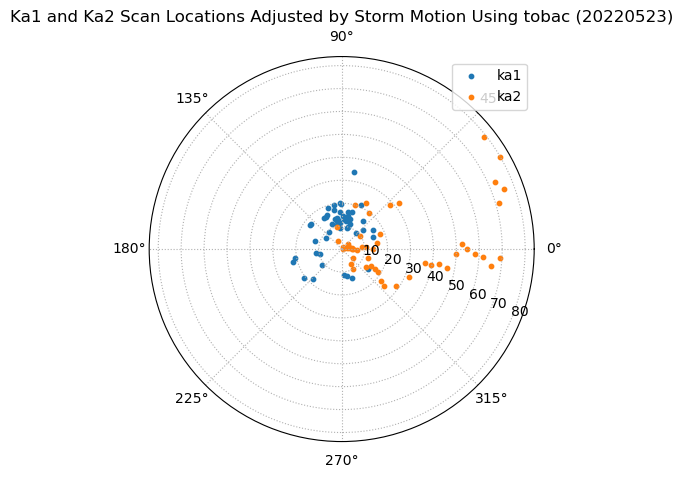

In [207]:
# bring in the figure

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(projection = 'polar')
ax.set_rmax(2)
#ax.set_rticks(distance_grid)
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True, linestyle = ':') # makes grid lines dotted
#ax.set_theta_zero_location('W', avg_storm_direction) # what is the N, S, E, W good for?
#ax.set_theta_offset(avg_storm_direction)
ax.set_title("Ka1 and Ka2 Scan Locations Adjusted by Storm Motion Using tobac (20220523)")
ax.plot()

# now that we have the figure set up, we can plot on it
# r --> great circle distance from lat and lon of storm to lat and lon of vehicle
# theta --> corrected bearing
# in polar plots the order of plotting is (theta, r)
theta = ka1_matching_bearing[2:53] - np.array(storm_direction_weighted) - 90 # adjust for true north in bearing calc being 90
theta_radians = theta * (np.pi/180)
r = ka1_distance_from_storm[2:53]# - np.array(ka1_matching_velocity) - np.array(storm_velocity)

#print(theta_radians)
#print(r)
#print(np.shape(theta))
#print(np.size(r))

theta2 = ka2_matching_bearing[2:53] - np.array(storm_direction_weighted) - 90
theta2_radians = theta2 * (np.pi/180)
r2 = ka2_distance_from_storm[2:53]# - np.array(ka2_matching_velocity) - np.array(storm_velocity)

#print(theta2_radians)
#print(r2)

ka1 = ax.scatter(theta_radians, r, s = 10) # s changes point size
ka2 = ax.scatter(theta2_radians, r2, s = 10)

ax.legend(['ka1', 'ka2'])
# plt.savefig('/Users/juliabman/Desktop/Seminar_Pictures/both_ka_positions.png')
plt.show()

In [227]:
print(theta)
print(theta_radians)

[-142.34770556 -260.39102142 -267.50008913 -195.79301676 -215.68189556
 -249.51896122 -258.97907693 -269.17137019 -216.94332307 -239.79720715
 -329.01320753 -307.43277184 -267.89666281 -169.23119031 -164.77282603
 -133.4178665    20.48509977  -36.70231209  -70.08480279  -78.83099011
  -84.64015539 -141.52149987 -273.06538228 -262.69300263 -167.53534317
 -233.67383713 -219.10776645 -246.60462061 -257.02892687 -274.43711412
 -279.05131833 -282.81696559 -317.43672617 -310.52969421 -293.52160511
 -280.16556367 -281.16920077 -279.58652624 -262.9761643  -260.15504525
 -265.48874278 -171.34730013 -285.01347093 -285.97501619 -289.26559944
 -286.09379198 -266.17332024 -258.94886477 -262.00401744 -244.133036
 -252.31412013]
[-2.48443614 -4.54468067 -4.6687573  -3.41723279 -3.76435921 -4.35492742
 -4.52003759 -4.69792666 -3.78637528 -4.1852508  -5.74236375 -5.3657141
 -4.67567882 -2.95364147 -2.87582833 -2.32858105  0.35753244 -0.64057619
 -1.22321056 -1.37586033 -1.47724939 -2.47001614 -4.765889

In [241]:
'''
this was my initial attempts at thresholding
'''
# # ka1
# theta_in_inflow = theta[(theta <= 90) & (theta >= -270)] # where theta is less than or = 90 etc
# r_array = np.array(r)
# r_in_inflow = r_array[(r_array <= 40)]

# # ka2
# theta2_in_inflow = theta2[(theta2 <= 90) & (theta2 >= -270)]
# r2_array = np.array(r2)
# r2_in_inflow = r2_array[(r2_array <= 40)]

'\nthis was my initial attempts at thresholding\n'

# Make sure all calculations are in radians as matplotlib only accepts radians to plot (correctly)!!!!

In [238]:
ka1_r = pd.Series(r)
ka1_theta=pd.Series(theta_radians)
ka1_df=pd.DataFrame(pd.concat([ka1_r,ka1_theta],axis=1))
ka1_df.columns=['r','theta']
print(np.shape(ka1_df))

#ka1_in_inflow=ka1_df[(ka1_df.r <= 40) & (ka1_df.theta <=90) or (ka1_df.theta > 270)]

ka1_negative_angles=ka1_df[(ka1_df.theta < 0)]
ka1_positive_angles=ka1_df[(ka1_df.theta >= 0)]
#print(ka1_negative_angles)

ka1_in_inflow_negative=ka1_negative_angles[(ka1_negative_angles.theta >= -(np.pi/2)) | (ka1_negative_angles.theta <=-(3 * np.pi)/2) & (ka1_negative_angles.r <=40)]
ka1_in_inflow_positive = ka1_positive_angles[(ka1_positive_angles.theta <= (np.pi/2)) | (ka1_positive_angles.theta >= (3 * np.pi)/2) & (ka1_positive_angles.r <= 40)]

#print(ka1_in_inflow_negative)

#ka1_in_inflow_negative_radians = ka1_in_inflow_negative * (np.pi/180)
#ka1_in_inflow_positive_radians = ka1_in_inflow_positive * (np.pi/180)

#ka1_in_inflow_positive=ka1_positive_angles[(ka1_positive_angles.theta >=270) & (ka1_positive_angles.theta <=90 & (ka1_negative_angles.r <=40)]
#print(ka1_in_inflow)
print(np.shape(ka1_in_inflow_negative))
#print(ka1_in_inflow_negative)
#ka1_in_inflow_df.columns = ['theta', 'r']

(51, 2)
(20, 2)


In [230]:
ka2_r = pd.Series(r2)
ka2_theta=pd.Series(theta2_radians)
ka2_df=pd.DataFrame(pd.concat([ka2_r,ka2_theta],axis=1))
ka2_df.columns=['r2','theta2']
print(np.shape(ka2_df))

#ka2_in_inflow=ka2_df[(ka2_df.r2 <= 40) & (ka2_df.theta2 <= 90) & (ka2_df.theta2 > 270]
ka2_in_inflow=ka2_df[(ka2_df.r2 <= 40) & (ka2_df.theta2 <=(np.pi/2)) & (ka2_df.theta2 > ((3 * np.pi)/2))]
#print(ka1_in_inflow)
print(np.shape(ka2_in_inflow))
#ka1_in_inflow_df.columns = ['theta', 'r']

(51, 2)
(0, 2)


In [239]:
ka2_r = pd.Series(r2)
ka2_theta=pd.Series(theta2_radians)
ka2_df=pd.DataFrame(pd.concat([ka2_r,ka2_theta],axis=1))
ka2_df.columns=['r2','theta2']
print(np.shape(ka2_df))

#ka1_in_inflow=ka1_df[(ka1_df.r <= 40) & (ka1_df.theta <=90) or (ka1_df.theta > 270)]

ka2_negative_angles=ka2_df[(ka2_df.theta2 < 0)]
ka2_positive_angles=ka2_df[(ka2_df.theta2 >= 0)]
#print(ka2_negative_angles)

#ka2_in_inflow_negative=ka2_negative_angles[(ka2_negative_angles.theta2 >= -90) | (ka2_negative_angles.theta2 <=-270) & (ka2_negative_angles.r2 <=40)]
#ka2_in_inflow_positive = ka2_positive_angles[(ka2_positive_angles.theta2 <= 90) | (ka2_positive_angles.theta2 >= 270) & (ka2_positive_angles.r2 <= 40)]

ka2_in_inflow_negative=ka2_negative_angles[(ka2_negative_angles.theta2 >= -(np.pi/2)) | (ka2_negative_angles.theta2 <=-(3 * np.pi)/2) & (ka2_negative_angles.r2 <=40)]
ka2_in_inflow_positive = ka2_positive_angles[(ka2_positive_angles.theta2 <= (np.pi/2)) | (ka2_positive_angles.theta2 >=(3 * np.pi)/2) & (ka2_positive_angles.r2 <= 40)]

#ka2_in_inflow_negative_radians = ka2_in_inflow_negative * (np.pi/180)
#ka2_in_inflow_positive_radians = ka2_in_inflow_positive * (np.pi/180)
#print(ka2_in_inflow_negative)

#ka1_in_inflow_positive=ka1_positive_angles[(ka1_positive_angles.theta >=270) & (ka1_positive_angles.theta <=90 & (ka1_negative_angles.r <=40)]
#print(ka1_in_inflow)
print(np.shape(ka2_in_inflow_negative))
#ka1_in_inflow_df.columns = ['theta', 'r']

(51, 2)
(35, 2)


16    0.357532
Name: theta, dtype: float64


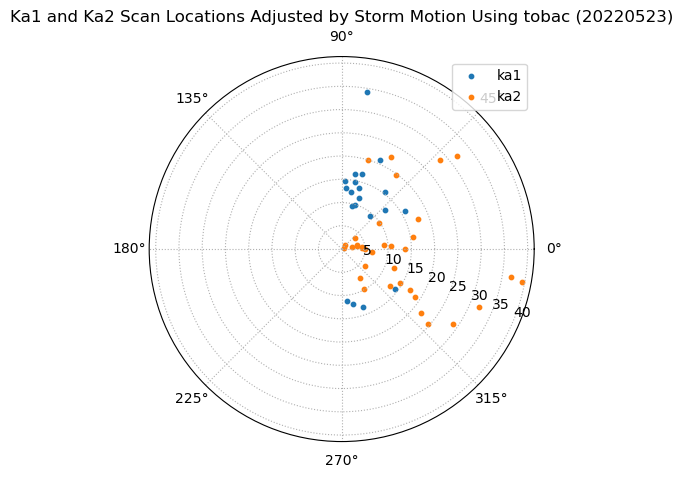

In [240]:
# bring in the figure

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(projection = 'polar')
ax.set_rmax(2)
#ax.set_rticks(distance_grid)
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True, linestyle = ':') # makes grid lines dotted
#ax.set_theta_zero_location('W', avg_storm_direction) # what is the N, S, E, W good for?
#ax.set_theta_offset(avg_storm_direction)
ax.set_title("Ka1 and Ka2 Scan Locations Adjusted by Storm Motion Using tobac (20220523)")
ax.plot()

# now that we have the figure set up, we can plot on it
# r --> great circle distance from lat and lon of storm to lat and lon of vehicle
# theta --> corrected bearing
# in polar plots the order of plotting is (theta, r)

print(ka1_in_inflow_positive.theta)

ka1 = ax.scatter(ka1_in_inflow_negative.theta, ka1_in_inflow_negative.r, s = 10)# s changes point size
ka2 = ax.scatter(ka2_in_inflow_negative.theta2, ka2_in_inflow_negative.r2, s = 10)

ax.legend(['ka1', 'ka2'])
# plt.savefig('/Users/juliabman/Desktop/Seminar_Pictures/both_ka_positions.png')
plt.show()

In [112]:
r_in_inflow

array([20.53482191, 19.5924016 , 16.11546538, 12.19828367,  8.31805671,
       11.73790172, 17.14879396, 19.5313082 , 17.40218476, 15.50975063,
       15.7649051 , 15.49561594, 20.03663005, 20.94218513, 22.15976625,
       18.18253529, 14.47730214, 14.2592255 , 13.36691695, 12.05292985,
       11.27163762, 10.99721184, 14.5790412 , 12.74282544,  9.69774263,
        9.48956233, 16.98853907, 15.99047342, 13.36783967, 13.27262576,
       34.17653653,  9.6046892 , 12.5615291 ,  9.32888774, 20.91135532,
       16.43751067, 14.78370665, 12.43617985, 11.55833865, 12.57389135,
       11.51280242, 11.49543007, 16.74071991, 13.60667312, 11.59203337,
        9.96754869,  9.21285957, 10.72855899, 13.59206854, 15.31689294,
       18.94902885])

In [113]:
theta_in_inflow

array([  37.65229444,  -80.39102142,  -87.50008913,  -15.79301676,
        -35.68189556,  -69.51896122,  -78.97907693,  -89.17137019,
        -36.94332307,  -59.79720715, -149.01320753, -127.43277184,
        -87.89666281,   10.76880969,   15.22717397,   46.5821335 ,
         38.47850013,  -93.06538228,  -82.69300263,   12.46465683,
        -53.67383713,  -39.10776645,  -66.60462061,  -77.02892687,
        -94.43711412,  -99.05131833, -102.81696559, -137.43672617,
       -130.52969421, -113.52160511, -100.16556367, -101.16920077,
        -99.58652624,  -82.9761643 ,  -80.15504525,  -85.48874278,
          8.65269987, -105.01347093, -105.97501619, -109.26559944,
       -106.09379198,  -86.17332024,  -78.94886477,  -82.00401744,
        -64.133036  ,  -72.31412013])

In [52]:
# # bring in the figure

# fig = plt.figure(figsize = (5,5))
# ax = fig.add_subplot(projection = 'polar')
# ax.set_rmax(2)
# #ax.set_rticks(distance_grid)
# ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
# ax.grid(True, linestyle = ':') # makes grid lines dotted
# #ax.set_theta_zero_location('W', avg_storm_direction) # what is the N, S, E, W good for?
# #ax.set_theta_offset(avg_storm_direction)
# ax.set_title("Ka1 Scan Locations Adjusted by Storm Motion Using tobac (20220523)")
# ax.plot()

# # now that we have the figure set up, we can plot on it
# # r --> great circle distance from lat and lon of storm to lat and lon of vehicle
# # theta --> corrected bearing
# # in polar plots the order of plotting is (theta, r)
# theta = (ka1_matching_bearing - storm_direction) - rotate_so_storm_dir_are_north
# r = ka1_distance_from_storm# - np.array(ka1_matching_velocity) - np.array(storm_velocity)

# theta2 = (ka2_matching_bearing - storm_direction) - rotate_so_storm_dir_are_north
# r2 = ka2_distance_from_storm# - np.array(ka2_matching_velocity) - np.array(storm_velocity)

# ka1 = ax.scatter(theta, r, s = 10) # s changes point size
# ka2 = ax.scatter(theta2, r2, s = 10)

# ax.legend(['ka1', 'ka2'])
# # plt.savefig('/Users/juliabman/Desktop/Seminar_Pictures/both_ka_positions.png')
# plt.show()

In [53]:
# # bring in the figure

# fig = plt.figure(figsize = (5,5))
# ax = fig.add_subplot(projection = 'polar')
# ax.set_rmax(2)
# #ax.set_rticks(distance_grid)
# ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
# ax.grid(True, linestyle = ':') # makes grid lines dotted
# #ax.set_theta_zero_location('W', avg_storm_direction) # what is the N, S, E, W good for?
# #ax.set_theta_offset(avg_storm_direction)
# ax.set_title("Ka1 Scan Locations Adjusted by Storm Motion Using tobac (20220523)")
# ax.plot()

# # now that we have the figure set up, we can plot on it
# # r --> great circle distance from lat and lon of storm to lat and lon of vehicle
# # theta --> corrected bearing
# # in polar plots the order of plotting is (theta, r)
# theta = ka1_matching_bearing - rotate_so_storm_dir_are_north
# r = ka1_distance_from_storm# - np.array(ka1_matching_velocity) - np.array(storm_velocity)

# theta2 = ka2_matching_bearing - rotate_so_storm_dir_are_north 
# r2 = ka2_distance_from_storm# - np.array(ka2_matching_velocity) - np.array(storm_velocity)

# ka1 = ax.scatter(theta, r, s = 10) # s changes point size
# ka2 = ax.scatter(theta2, r2, s = 10)

# ax.legend(['ka1', 'ka2'])
# # plt.savefig('/Users/juliabman/Desktop/Seminar_Pictures/both_ka_positions.png')
# plt.show()

In [54]:
# # bring in the figure

# fig = plt.figure(figsize = (5,5))
# ax = fig.add_subplot(projection = 'polar')
# ax.set_rmax(2)
# #ax.set_rticks(distance_grid)
# ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
# ax.grid(True, linestyle = ':') # makes grid lines dotted
# #ax.set_theta_zero_location('W', avg_storm_direction) # what is the N, S, E, W good for?
# #ax.set_theta_offset(avg_storm_direction)
# ax.set_title("Ka1 Scan Locations Adjusted by Storm Motion Using tobac (20220523)")
# ax.plot()

# # now that we have the figure set up, we can plot on it
# # r --> great circle distance from lat and lon of storm to lat and lon of vehicle
# # theta --> corrected bearing
# # in polar plots the order of plotting is (theta, r)
# theta = ka1_matching_bearing - np.array(360)#rotate_so_storm_dir_are_north
# r = ka1_distance_from_storm# - np.array(ka1_matching_velocity) - np.array(storm_velocity)

# theta2 = ka2_matching_bearing - np.array(360) #rotate_so_storm_dir_are_north
# r2 = ka2_distance_from_storm# - np.array(ka2_matching_velocity) - np.array(storm_velocity)

# ka1 = ax.scatter(theta, r, s = 10) # s changes point size
# ka2 = ax.scatter(theta2, r2, s = 10)

# ax.legend(['ka1', 'ka2'])
# # plt.savefig('/Users/juliabman/Desktop/Seminar_Pictures/both_ka_positions.png')
# plt.show()

In [55]:
# # bring in the figure

# fig = plt.figure(figsize = (5,5))
# ax = fig.add_subplot(projection = 'polar')
# ax.set_rmax(2)
# #ax.set_rticks(distance_grid)
# ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
# ax.grid(True, linestyle = ':') # makes grid lines dotted
# #ax.set_theta_zero_location('W', avg_storm_direction) # what is the N, S, E, W good for?
# #ax.set_theta_offset(avg_storm_direction)
# ax.set_title("Ka1 Scan Locations Adjusted by Storm Motion Using tobac (20220523)")
# ax.plot()

# # now that we have the figure set up, we can plot on it
# # r --> great circle distance from lat and lon of storm to lat and lon of vehicle
# # theta --> corrected bearing
# # in polar plots the order of plotting is (theta, r)
# theta = ka1_matching_bearing #rotate_so_storm_dir_are_north
# r = ka1_distance_from_storm# - np.array(ka1_matching_velocity) - np.array(storm_velocity)

# theta2 = ka2_matching_bearing #rotate_so_storm_dir_are_north
# r2 = ka2_distance_from_storm# - np.array(ka2_matching_velocity) - np.array(storm_velocity)

# ka1 = ax.scatter(theta, r, s = 10) # s changes point size
# ka2 = ax.scatter(theta2, r2, s = 10)

# ax.legend(['ka1', 'ka2'])
# # plt.savefig('/Users/juliabman/Desktop/Seminar_Pictures/both_ka_positions.png')
# plt.show()

In [56]:
# # bring in the figure

# fig = plt.figure(figsize = (5,5))
# ax = fig.add_subplot(projection = 'polar')
# ax.set_rmax(2)
# #ax.set_rticks(distance_grid)
# ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
# ax.grid(True, linestyle = ':') # makes grid lines dotted
# #ax.set_theta_zero_location('W', avg_storm_direction) # what is the N, S, E, W good for?
# #ax.set_theta_offset(avg_storm_direction)
# ax.set_title("Ka1 Scan Locations Adjusted by Storm Motion Using tobac (20220523)")
# ax.plot()

# # now that we have the figure set up, we can plot on it
# # r --> great circle distance from lat and lon of storm to lat and lon of vehicle
# # theta --> corrected bearing
# # in polar plots the order of plotting is (theta, r)
# theta = (ka1_matching_bearing - storm_direction) - np.array(360)
# r = ka1_distance_from_storm# - np.array(ka1_matching_velocity) - np.array(storm_velocity)

# theta2 = (ka2_matching_bearing - storm_direction) - np.array(360)
# r2 = ka2_distance_from_storm# - np.array(ka2_matching_velocity) - np.array(storm_velocity)

# ka1 = ax.scatter(theta, r, s = 10) # s changes point size
# ka2 = ax.scatter(theta2, r2, s = 10)

# ax.legend(['ka1', 'ka2'])
# # plt.savefig('/Users/juliabman/Desktop/Seminar_Pictures/both_ka_positions.png')
# plt.show()

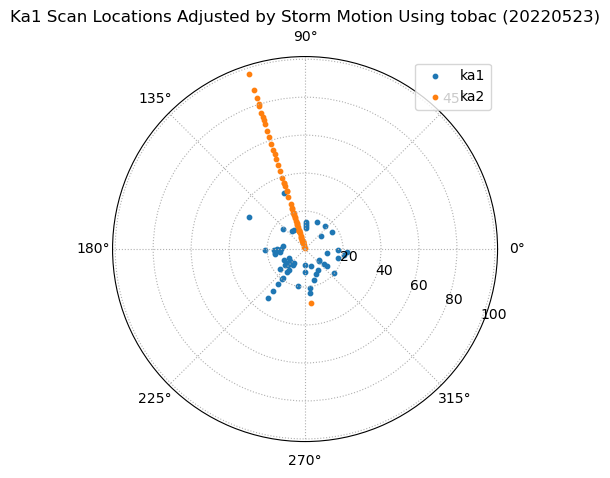

In [57]:
# bring in the figure

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(projection = 'polar')
ax.set_rmax(2)
#ax.set_rticks(distance_grid)
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True, linestyle = ':') # makes grid lines dotted
#ax.set_theta_zero_location('W', avg_storm_direction) # what is the N, S, E, W good for?
#ax.set_theta_offset(avg_storm_direction)
ax.set_title("Ka1 Scan Locations Adjusted by Storm Motion Using tobac (20220523)")
ax.plot()

# now that we have the figure set up, we can plot on it
# r --> great circle distance from lat and lon of storm to lat and lon of vehicle
# theta --> corrected bearing
# in polar plots the order of plotting is (theta, r)
theta = ka1_matching_bearing - avg_storm_direction
r = ka1_distance_from_storm# - np.array(ka1_matching_velocity) - np.array(storm_velocity)

theta2 = ka2_matching_bearing - avg_storm_direction
r2 = ka2_distance_from_storm# - np.array(ka2_matching_velocity) - np.array(storm_velocity)

ka1 = ax.scatter(theta, r, s = 10) # s changes point size
ka2 = ax.scatter(theta2, r2, s = 10)

ax.legend(['ka1', 'ka2'])
# plt.savefig('/Users/juliabman/Desktop/Seminar_Pictures/both_ka_positions.png')
plt.show()

In [58]:
weights = np.array([0.05, 0.2, 0.5, 0.2, 0.05])
weighted_average_storm_motion = []
for motion in storm_direction:
    weighted_motion = sum(motion * weights)/ sum(weights)
    weighted_average_storm_motion.append(weighted_motion)

In [59]:
weighted_average_storm_motion = np.array(weighted_average_storm_motion)
print(weighted_average_storm_motion)
print(storm_direction)

[         nan 212.60753752 226.61056586 231.83395216 248.04678545
 201.97764695 177.85356961 209.39660727 266.58083671 262.75656633
 246.48003198 318.76709756 345.16861306 334.91100603 319.7525226
 247.30812379 253.68507854 266.10616329 285.0524691   44.42990666
 255.87470916 266.02174286 251.84008293 269.58955205 263.29908411
 273.72917642 353.53316863  28.09731842 288.92330283 266.83933125
 291.62466122 308.561459   298.89933623 299.60862642 312.24391711
 315.66012556 305.75188343 296.33849804 268.63369715 285.64467386
 275.08973097 287.50506619 271.40055772 262.52995339 271.86551856
 274.50828953 269.91089875 278.95090077 288.08905664 242.69487007
 237.89129112 272.25096777 210.7975318  238.72606504 251.49153518
 296.2200721 ]
[         nan 212.60753752 226.61056586 231.83395216 248.04678545
 201.97764695 177.85356961 209.39660727 266.58083671 262.75656633
 246.48003198 318.76709756 345.16861306 334.91100603 319.7525226
 247.30812379 253.68507854 266.10616329 285.0524691   44.429906

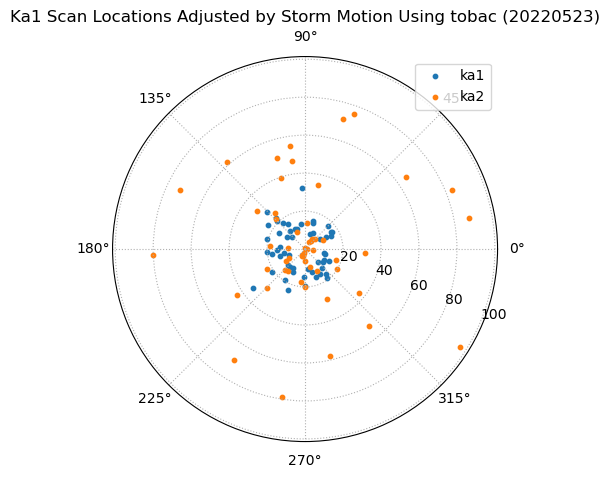

In [60]:
# bring in the figure

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(projection = 'polar')
ax.set_rmax(2)
#ax.set_rticks(distance_grid)
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True, linestyle = ':') # makes grid lines dotted
#ax.set_theta_zero_location('W', avg_storm_direction) # what is the N, S, E, W good for?
#ax.set_theta_offset(avg_storm_direction)
ax.set_title("Ka1 Scan Locations Adjusted by Storm Motion Using tobac (20220523)")
ax.plot()

# now that we have the figure set up, we can plot on it
# r --> great circle distance from lat and lon of storm to lat and lon of vehicle
# theta --> corrected bearing
# in polar plots the order of plotting is (theta, r)
theta = ka1_matching_bearing - weighted_average_storm_motion
r = ka1_distance_from_storm# - np.array(ka1_matching_velocity) - np.array(storm_velocity)

theta2 = ka2_matching_bearing - weighted_average_storm_motion
r2 = ka2_distance_from_storm# - np.array(ka2_matching_velocity) - np.array(storm_velocity)

ka1 = ax.scatter(theta, r, s = 10) # s changes point size
ka2 = ax.scatter(theta2, r2, s = 10)

ax.legend(['ka1', 'ka2'])
# plt.savefig('/Users/juliabman/Desktop/Seminar_Pictures/both_ka_positions.png')
plt.show()

In [61]:
tobac_features_xr = xr.open_dataset(tobac_file)
idx = tobac_features_xr['idx'].data
morton_storm_indeces_idx = np.where(idx == 29)
#morton_storm_indeces = np.where(cell == 29)
#print(morton_storm_indeces)
tobac_times = tobac_features_xr['time']
tobac_lats = np.array(tobac_features_xr['latitude'])
tobac_lons = np.array(tobac_features_xr['longitude'])

idx_29_lats = tobac_lats[morton_storm_indeces_idx]
idx_29_lons = tobac_lons[morton_storm_indeces_idx]
idx_29_times = tobac_times[morton_storm_indeces_idx]

morton_tobac_times_datetime_idx = idx_29_times.astype('datetime64[s]')
print(morton_tobac_times_datetime_idx)

print(idx_29_lats)
print(np.size(idx_29_lats))
print(np.size(idx_29_lons))

<xarray.DataArray 'time' (index: 13)>
array(['2022-05-24T00:42:49.000000000', '2022-05-24T00:49:23.000000000',
       '2022-05-24T00:55:57.000000000', '2022-05-24T01:02:32.000000000',
       '2022-05-24T03:00:48.000000000', '2022-05-24T03:07:24.000000000',
       '2022-05-24T03:13:57.000000000', '2022-05-24T03:20:32.000000000',
       '2022-05-24T03:27:07.000000000', '2022-05-24T03:40:16.000000000',
       '2022-05-24T03:46:50.000000000', '2022-05-24T03:53:24.000000000',
       '2022-05-24T03:59:58.000000000'], dtype='datetime64[ns]')
Coordinates:
  * index    (index) int64 407 421 433 447 640 658 679 700 720 761 785 808 837
[33.75333783 34.57511342 34.57648773 34.57998042 34.45498722 34.45272429
 34.43816628 34.19611471 34.2008334  34.63303114 34.75095298 34.70575277
 32.32076956]
13
13


/var/folders/4f/9s_4__q16tx5t8vmww4mv03h0000gn/T/ipykernel_14683/2470369681.py:14: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  morton_tobac_times_datetime_idx = idx_29_times.astype('datetime64[s]')


In [62]:
ka1_times_aligning_with_tobac_idx = []
ka1_matching_lats_idx = []
ka1_matching_lons_idx = []
ka1_matching_bearing_idx = []
ka1_matching_velocity_idx = []

for a_tobac_time_idx in morton_tobac_times_datetime_idx:
    absolute_diff_between_times_idx = np.abs(array_dealiased_vad_ka1_times_datetime - a_tobac_time_idx.data)
    print(a_tobac_time_idx.data)
    #print(array_dealiased_vad_ka1_times_datetime_0524)
    #print(absolute_diff_between_times_again)
    index_of_smallest_time_between_idx = np.argmin(absolute_diff_between_times_idx) # np.argmin returns the index of the min value
    # access the index of the smallest value
    #print(index_of_smallest_time_between_again)
    access_smallest_value_idx = array_dealiased_vad_ka1_times_datetime[index_of_smallest_time_between_idx]
    
    tobac_lats_for_ka_idx = latmean_array_ka1[index_of_smallest_time_between_idx]
    tobac_lons_for_ka_idx = lonmean_array_ka1[index_of_smallest_time_between_idx]
    tobac_bearing_for_idx = bearmean_array_ka1[index_of_smallest_time_between_idx]
    tobac_vel_for_idx = velmean_array_ka1[index_of_smallest_time_between_idx]
    #print(f"the ka time is {a_ka_time}")
    #print(f" the tobac time is {access_smallest_value}")
    #print(index_of_smallest_time_between_again)
    ka1_times_aligning_with_tobac_idx.append(access_smallest_value_idx)
    ka1_matching_lats_idx.append(tobac_lats_for_ka_idx)
    ka1_matching_lons_idx.append(tobac_lons_for_ka_idx)
    ka1_matching_bearing_idx.append(tobac_bearing_for_idx)
    ka1_matching_velocity_idx.append(tobac_vel_for_idx)

2022-05-24T00:42:49.000000000
2022-05-24T00:49:23.000000000
2022-05-24T00:55:57.000000000
2022-05-24T01:02:32.000000000
2022-05-24T03:00:48.000000000
2022-05-24T03:07:24.000000000
2022-05-24T03:13:57.000000000
2022-05-24T03:20:32.000000000
2022-05-24T03:27:07.000000000
2022-05-24T03:40:16.000000000
2022-05-24T03:46:50.000000000
2022-05-24T03:53:24.000000000
2022-05-24T03:59:58.000000000


In [75]:
np.size(ka1_matching_bearing_idx)

13

In [64]:
ka2_times_aligning_with_tobac_idx = []
ka2_matching_lats_idx = []
ka2_matching_lons_idx = []
ka2_matching_bearing_idx = []
ka2_matching_velocity_idx = []

for a_tobac_time_idx_2 in morton_tobac_times_datetime_idx:
    absolute_diff_between_times_idx_2 = np.abs(array_dealiased_vad_ka2_times_datetime - a_tobac_time_idx_2.data)
    print(a_tobac_time_idx_2.data)
    #print(array_dealiased_vad_ka1_times_datetime_0524)
    #print(absolute_diff_between_times_again)
    index_of_smallest_time_between_idx_2 = np.argmin(absolute_diff_between_times_idx_2) # np.argmin returns the index of the min value
    # access the index of the smallest value
    #print(index_of_smallest_time_between_again)
    access_smallest_value_idx_2 = array_dealiased_vad_ka2_times_datetime[index_of_smallest_time_between_idx_2]
    
    tobac_lats_for_ka_idx_2 = latmean_array_ka2[index_of_smallest_time_between_idx_2]
    tobac_lons_for_ka_idx_2 = lonmean_array_ka2[index_of_smallest_time_between_idx_2]
    tobac_bearing_for_idx_2 = bearmean_array_ka2[index_of_smallest_time_between_idx_2]
    tobac_vel_for_idx_2 = velmean_array_ka2[index_of_smallest_time_between_idx_2]
    #print(f"the ka time is {a_ka_time}")
    #print(f" the tobac time is {access_smallest_value}")
    #print(index_of_smallest_time_between_again)
    ka2_times_aligning_with_tobac_idx.append(access_smallest_value_idx_2)
    ka2_matching_lats_idx.append(tobac_lats_for_ka_idx_2)
    ka2_matching_lons_idx.append(tobac_lons_for_ka_idx_2)
    ka2_matching_bearing_idx.append(tobac_bearing_for_idx_2)
    ka2_matching_velocity_idx.append(tobac_vel_for_idx_2)

2022-05-24T00:42:49.000000000
2022-05-24T00:49:23.000000000
2022-05-24T00:55:57.000000000
2022-05-24T01:02:32.000000000
2022-05-24T03:00:48.000000000
2022-05-24T03:07:24.000000000
2022-05-24T03:13:57.000000000
2022-05-24T03:20:32.000000000
2022-05-24T03:27:07.000000000
2022-05-24T03:40:16.000000000
2022-05-24T03:46:50.000000000
2022-05-24T03:53:24.000000000
2022-05-24T03:59:58.000000000


In [65]:
ka1_distance_from_storm_idx = []
for index in np.arange(0, len(ka1_matching_lats_idx)):
    distance = measure(morton_tobac_lats[index], morton_tobac_lons[index], ka1_matching_lats_idx[index], ka1_matching_lons_idx[index])
    ka1_distance_from_storm_idx.append(distance)

ka2_distance_from_storm_idx = []
for index in np.arange(0, len(ka2_matching_lats_idx)):
    distance = measure(morton_tobac_lats[index], morton_tobac_lons[index], ka2_matching_lats_idx[index], ka2_matching_lons_idx[index])
    ka2_distance_from_storm_idx.append(distance)

In [66]:
storm_velocity_idx=[]
storm_direction_idx=[]
time_initial_idx = ka1_times_aligning_with_tobac_idx[0].astype(float)
time_final_idx = ka1_times_aligning_with_tobac_idx[-1].astype(float)

for id in np.arange(0,len(idx_29_lats)-1,1): # using storm_lat as length makes these plots different that plot test 2, which uses length of storm location csv
    velocity_idx = calc_velocity(idx_29_lats[id], idx_29_lons[id],
                             idx_29_lats[id+1],idx_29_lons[id+1],
                             time_initial_idx, time_final_idx)
                             #storm_decimalsec[i],storm_decimalsec[i+1])
    print(velocity_idx)
    storm_velocity_idx.append(velocity_idx)
    
    direction_idx = get_bearing(idx_29_lats[id],idx_29_lons[id],
                            idx_29_lats[id+1], idx_29_lons[id+1])
    storm_direction_idx.append(direction_idx)
    
storm_velocity_idx = np.append([np.nan],storm_velocity_idx) # in meters/sec
storm_direction_idx = np.append([np.nan],storm_direction_idx) # in degrees

10.094419988808815
0.053208270278363674
0.23133500562080994
1.5333896380060872
0.21488701222485115
0.19523310239110223
3.292879460748271
0.5440939401358349
13.564575145839923
17.70003361614639
4.088625980933625
29.273104940134733


In [67]:
storm_direction_df = pd.DataFrame(storm_direction_idx)

direction_corrected_idx = storm_direction_df.dropna()

avg_storm_direction_idx = np.average(direction_corrected_idx)

In [68]:
direction_corrected_array_idx = np.array(direction_corrected_idx)

In [76]:
np.size(direction_corrected_array_idx)

12

In [90]:
flat_direction_corrected_array_idx = direction_corrected_array_idx.flatten()

In [70]:
weights = np.array([0.05, 0.2, 0.5, 0.2, 0.05])
storm_direction_weighted_idx = []

for id in range(len((direction_corrected_idx))):
    jd = id+2 # if we start any further it'll loop to the back values of the array and average them
    #print(j)
    storm_direction_over_25_minutes_idx = np.array([direction_corrected_array_idx[jd-2], direction_corrected_array_idx[jd-1], 
                                            direction_corrected_array_idx[jd], direction_corrected_array_idx[jd+1], direction_corrected_array_idx[jd+2]])
    #print(storm_direction_over_25_minutes_idx)
    flat_idx = storm_direction_over_25_minutes_idx.flatten()
    #print(np.shape(flat))
    #print(np.shape(weights))
    #print(storm_direction_over_25_minutes)
    #storm_avg_weighted = sum(storm_direction_over_25_minutes * weights)/ sum(weights)
    storm_avg_weighted_idx = np.average(flat_idx, weights = weights)
    print(storm_avg_weighted_idx)
    storm_direction_weighted_idx.append(storm_avg_weighted_idx)

203.00648166492752
136.79600267686993
220.21657926337153
241.89882334439454
159.03658366539008
207.96480134648752
210.30060977815168
165.7433498427215


IndexError: index 12 is out of bounds for axis 0 with size 12

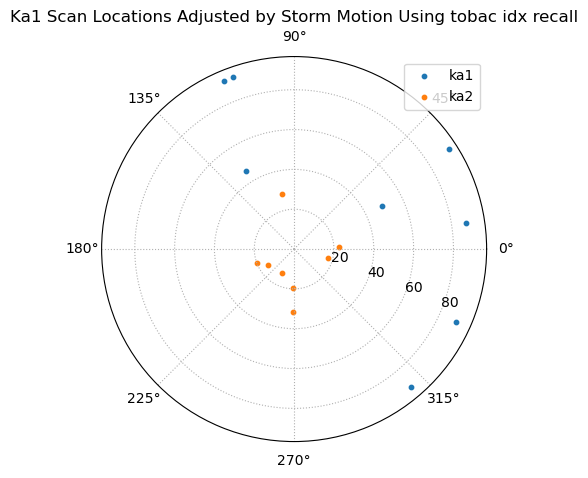

In [71]:
# bring in the figure

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(projection = 'polar')
ax.set_rmax(2)
#ax.set_rticks(distance_grid)
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True, linestyle = ':') # makes grid lines dotted
#ax.set_theta_zero_location('W', avg_storm_direction) # what is the N, S, E, W good for?
#ax.set_theta_offset(avg_storm_direction)
ax.set_title("Ka1 Scan Locations Adjusted by Storm Motion Using tobac idx recall")
ax.plot()

# now that we have the figure set up, we can plot on it
# r --> great circle distance from lat and lon of storm to lat and lon of vehicle
# theta --> corrected bearing
# in polar plots the order of plotting is (theta, r)
theta_idx = ka1_matching_bearing_idx[2:10] - np.array(storm_direction_weighted_idx)
r_idx = ka1_distance_from_storm_idx[2:10]# - np.array(ka1_matching_velocity) - np.array(storm_velocity)

theta2_idx = ka2_matching_bearing_idx[2:10] - np.array(storm_direction_weighted_idx)
r2_idx = ka2_distance_from_storm_idx[2:10]# - np.array(ka2_matching_velocity) - np.array(storm_velocity)

ka1_idx = ax.scatter(theta_idx, r_idx, s = 10) # s changes point size
ka2_idx = ax.scatter(theta2_idx, r2_idx, s = 10)

ax.legend(['ka1', 'ka2'])
# plt.savefig('/Users/juliabman/Desktop/Seminar_Pictures/both_ka_positions.png')
plt.show()

(12,)
13
12
12


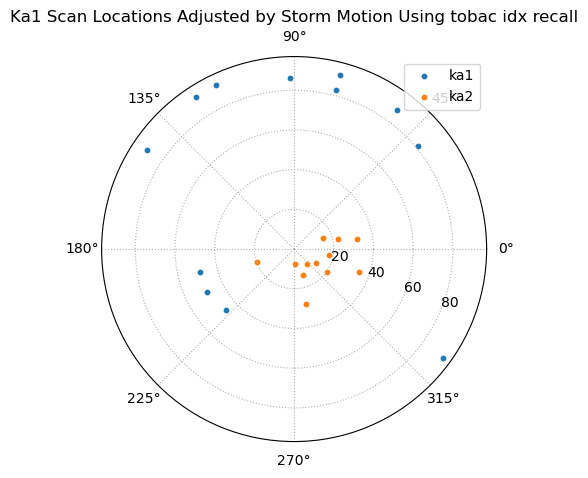

In [93]:
# bring in the figure

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(projection = 'polar')
ax.set_rmax(2)
#ax.set_rticks(distance_grid)
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True, linestyle = ':') # makes grid lines dotted
#ax.set_theta_zero_location('W', avg_storm_direction) # what is the N, S, E, W good for?
#ax.set_theta_offset(avg_storm_direction)
ax.set_title("Ka1 Scan Locations Adjusted by Storm Motion Using tobac idx recall")
ax.plot()

# now that we have the figure set up, we can plot on it
# r --> great circle distance from lat and lon of storm to lat and lon of vehicle
# theta --> corrected bearing
# in polar plots the order of plotting is (theta, r)
theta_idx_ = ka1_matching_bearing_idx[1:13] - np.array(flat_direction_corrected_array_idx)
r_idx_ = ka1_distance_from_storm_idx[1:13]# - np.array(ka1_matching_velocity) - np.array(storm_velocity)

print(np.shape(theta_idx_))
print(np.size(ka1_matching_bearing_idx))
print(np.size(direction_corrected_array_idx))
print(np.size(r_idx_))
      
theta2_idx_ = ka2_matching_bearing_idx[1:13] - np.array(flat_direction_corrected_array_idx)
r2_idx_ = ka2_distance_from_storm_idx[1:13]# - np.array(ka2_matching_velocity) - np.array(storm_velocity)

ka1_idx_ = ax.scatter(theta_idx_, r_idx_, s = 10) # s changes point size
ka2_idx_ = ax.scatter(theta2_idx_, r2_idx_, s = 10)

ax.legend(['ka1', 'ka2'])
# plt.savefig('/Users/juliabman/Desktop/Seminar_Pictures/both_ka_positions.png')
plt.show()